In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd "/content/drive/MyDrive/Colab Notebooks/yolov5"

/content/drive/MyDrive/Colab Notebooks/yolov5


In [3]:
import torch
import numpy as np
import cv2
from utils.datasets import letterbox
from utils.general import non_max_suppression, scale_coords
from utils.plots import Annotator
from tqdm import tqdm
from google.colab.patches import cv2_imshow

In [4]:
PED_MODEL_PATH = '/content/drive/MyDrive/Colab Notebooks/yolov5/runs/train/exp72/weights/best.pt'
CROSS_MODEL_PATH = '/content/drive/MyDrive/Colab Notebooks/yolov5/runs/train/exp70/weights/best.pt'

TEST_VIDEO_PATH = '/content/drive/MyDrive/Colab Notebooks/test-video/'
TEST_VIDEO_SAVE_PATH = TEST_VIDEO_PATH + 'output/'

img_size = 640
conf_thres = 0.1
iou_thres = 0.45
max_det = 1000
classes = None
agnostic_nms = False

In [5]:
ped_device = torch.device('cpu')
print(ped_device)
ped_ckpt = torch.load(PED_MODEL_PATH, map_location = ped_device)
ped_model = ped_ckpt['ema' if ped_ckpt.get('cma') else 'model'].float().fuse().eval()
ped_class_names = ['보행자', '차량']
ped_stride = int(ped_model.stride.max())
ped_colors = ((50, 50, 50), (255, 0, 0))

cpu


INFO:yolov5:Fusing layers... 
Fusing layers... 
INFO:yolov5:Model summary: 213 layers, 7015519 parameters, 0 gradients
Model summary: 213 layers, 7015519 parameters, 0 gradients


In [6]:
cross_device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(cross_device)
cross_ckpt = torch.load(CROSS_MODEL_PATH, map_location = cross_device)
cross_model = cross_ckpt['ema' if cross_ckpt.get('cma') else 'model'].float().fuse().eval()
cross_class_names = ['횡단보도', '빨간불', '초록불']
cross_stride = int(cross_model.stride.max())
cross_colors = ((255, 0, 255), (0, 0, 255), (0, 255, 0))

cuda:0


INFO:yolov5:Fusing layers... 
Fusing layers... 
INFO:yolov5:Model summary: 213 layers, 7018216 parameters, 0 gradients
Model summary: 213 layers, 7018216 parameters, 0 gradients


In [7]:
cap = cv2.VideoCapture(TEST_VIDEO_PATH + 'acro2.mp4')

fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
out = cv2.VideoWriter(TEST_VIDEO_SAVE_PATH + 'output31.mp4', fourcc, cap.get(cv2.CAP_PROP_FPS), (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))))
frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

cx1, cy1, cx2, cy2 = 0, 0, 0, 0

In [8]:
def detect(img, stride, device, model, class_names, colors, annotator):
    global cx1, cy1, cx2, cy2
    H, W, _ = img.shape

    img_input = letterbox(img, img_size, stride = stride)[0]
    img_input = img_input.transpose((2, 0, 1))[::-1]
    img_input = np.ascontiguousarray(img_input)
    img_input = torch.from_numpy(img_input).to(device)
    img_input = img_input.float()
    img_input /= 255.
    img_input = img_input.unsqueeze(0)

    pred = model(img_input, augment = False, visualize = False)[0]
    pred = non_max_suppression(pred, conf_thres, iou_thres, classes, agnostic_nms, max_det = max_det)[0]
    pred = pred.cpu().numpy()

    pred[:, :4] = scale_coords(img_input.shape[2:], pred[:, :4], img.shape).round()

    peds=[]

    for p in pred:
        class_name = class_names[int(p[5])]
        x1, y1, x2, y2 = p[:4]

        if class_name == '횡단보도':
          # cx1, cy1, cx2, cy2 = x1, y1, x2, y2
          continue
        elif class_name == '보행자':
          peds.append([x1, y1, x2, y2])
        annotator.box_label([x1, y1, x2, y2], '%s %d' % (class_name, float(p[4]) * 100), color=colors[int(p[5])])
    
    return peds

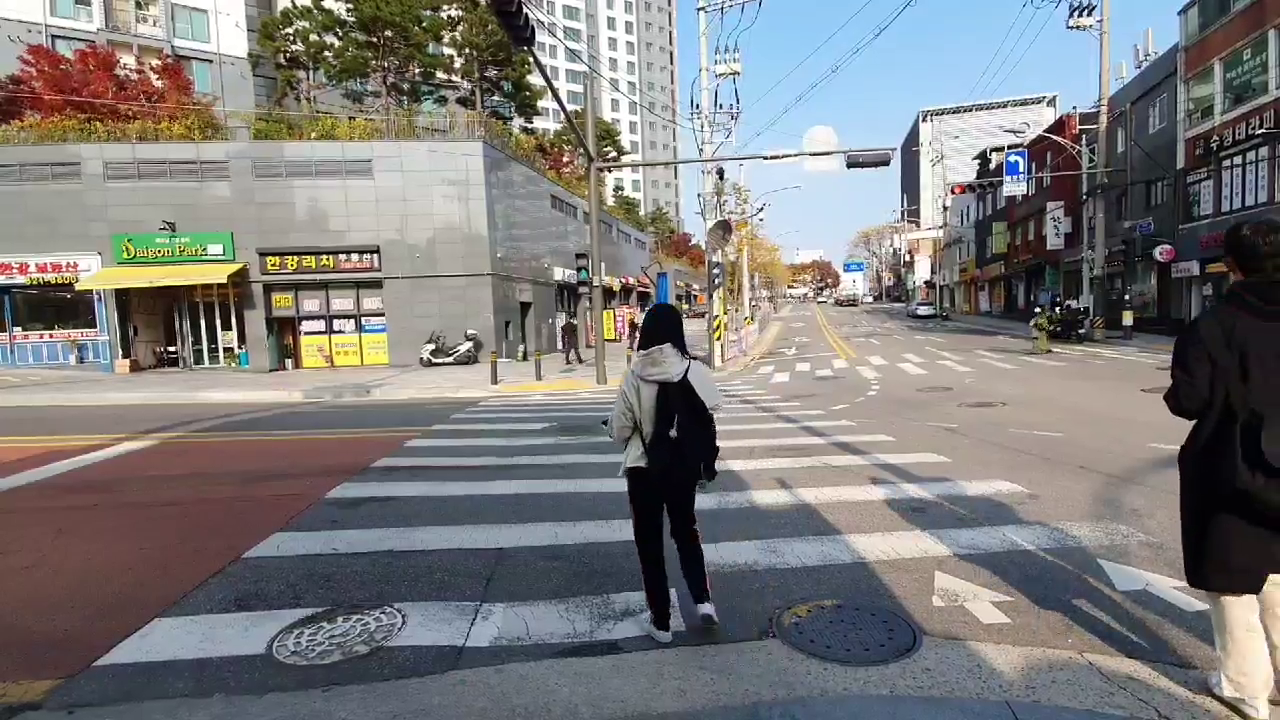

DisabledFunctionError: ignored

In [24]:
# def click_event(event, x, y, flags, params):
#   print(x, ' ', y)

# ret, img = cap.read()

# cv2.imshow('image', img)
# cv2.setMouseCallback('image', click_event)
# cv2.waitkey(0)
# cv2.destroyAllWindows()

In [ ]:
cx1, cy1, cx2, cy2 = 0, 0, 0, 0

ret, img = cap.read()

H, W, _ = img.shape

img_input = letterbox(img, img_size, stride = cross_stride)[0]
img_input = img_input.transpose((2, 0, 1))[::-1]
img_input = np.ascontiguousarray(img_input)
img_input = torch.from_numpy(img_input).to(cross_device)
img_input = img_input.float()
img_input /= 255.
img_input = img_input.unsqueeze(0)

pred = cross_model(img_input, augment = False, visualize = False)[0]
pred = non_max_suppression(pred, conf_thres, iou_thres, classes, agnostic_nms, max_det = max_det)[0]
pred = pred.cpu().numpy()

pred[:, :4] = scale_coords(img_input.shape[2:], pred[:, :4], img.shape).round()

for p in pred:
  class_name = cross_class_names[int(p[5])]
  print(class_name)
  print(p[:4])

  if class_name == '횡단보도':
    cx1, cy1, cx2, cy2 = p[:4]
  
print(cx1, cy1, cx2, cy2, sep=', ')

In [ ]:
safe_x1, safe_y1 = 780, 536
safe_x2, safe_y2 = 1130, 536

cur_frame = 1
pbar = tqdm(total=frames)

while cap.isOpened():
  ret, img = cap.read()
  if not ret:
    break

  pbar.update(cur_frame)

  annotator = Annotator(img.copy(), line_width = 3, example = '한글', font = 'data/malgun.ttf')

  peds=detect(img, ped_stride, ped_device, ped_model, ped_class_names, ped_colors, annotator)
  detect(img, cross_stride, cross_device, cross_model, cross_class_names, cross_colors, annotator)
  annotator.box_label([cx1, cy1, cx2, cy2], '횡단보도', color=(255, 0, 255))

  result_img = annotator.result()
  cv2.rectangle(result_img, (int(safe_x1), int(safe_y1)), (int(safe_x2), int(cy1)), (255, 255, 255), 3)

  if peds:
    for ped in peds:
      px1, py1, px2, py2 = ped
      if int(safe_y1) <= int(py2) <= int(cy1) and int(safe_x1) <= int(px1) and int(px2) <= int(safe_x2):
        cv2.putText(result_img, "Caution!!", (150, 150), cv2.FONT_HERSHEY_PLAIN, 12, (0, 255, 255), 6, cv2.LINE_AA)
      if int(cy1) <= int(py2) <= int(cx2) and int(cx1) <= int(px1) and int(px2) <= int(cx2):
        cv2.putText(result_img, "Warning!!", (150, 300), cv2.FONT_HERSHEY_PLAIN, 12, (0, 0, 255), 6, cv2.LINE_AA)


  out.write(result_img)
  if cv2.waitKey(1) == ord('q'):
    break


100%|██████████| 1275/1275 [05:47<00:00,  3.67it/s]

100%|██████████| 1275/1275 [02:51<00:00,  7.85it/s]

In [ ]:
cap.release()
out.release()